In [1]:
import networkx as nx
import random
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from networkx.algorithms.community import greedy_modularity_communities
from tabulate import tabulate

# Inizialize the graph

In [2]:
def get_giant_component(G):
    """
    Get the largest connected component of the graph.
    
    Parameters:
    G (nx.Graph): The input networkx graph.
    
    Returns:
    tuple: The largest connected component as a graph and its size.
    """
    if len(G) == 0:
        return G, 0
    giant_component = max(nx.connected_components(G), key=len)
    G = G.subgraph(giant_component).copy()
    return G, G.number_of_nodes()

In [3]:
tsv_file_path = "soc-redditHyperlinks-body.tsv"

Reddit_graph = nx.DiGraph()

# Read the TSV file and add nodes and edges to the graph
with open(tsv_file_path, 'r') as file:
    # Skip the header line
    next(file)
    for line in file:
        # Split the line by tab
        data = line.strip().split('\t')
        if len(data) == 6:
            source_subreddit, target_subreddit, _, _, _, _ = data
            # Add source and target nodes to the graph if they don't exist
            if source_subreddit not in Reddit_graph:
                Reddit_graph.add_node(source_subreddit)
            if target_subreddit not in Reddit_graph:
                Reddit_graph.add_node(target_subreddit)
            # Add directed edge from source to target
            Reddit_graph.add_edge(source_subreddit, target_subreddit)

# Extract the biggest stronly connected component of the Graph
giant_component = max(nx.strongly_connected_components(Reddit_graph), key=len)
G_strong = Reddit_graph.subgraph(giant_component)

# Make the graph undirected
Reddit_undirected = G_strong.to_undirected()

In [4]:
#Print some basic information of the graph

# Number of Nodes and Edges
print("Number of Nodes: ", Reddit_undirected.number_of_nodes())
print("Number of Edges: ", Reddit_undirected.number_of_edges())

# Average Node Degree
average_node_degree = np.mean([d for n, d in Reddit_undirected.degree()])
print("Average Node Degree: ", average_node_degree)

# Compute the density of the Graph
print("Density of the Graph: ", nx.density(Reddit_undirected))

Number of Nodes:  11564
Number of Edges:  84812
Average Node Degree:  14.668280871670703
Density of the Graph:  0.0012685532190323187


# Degree distribution

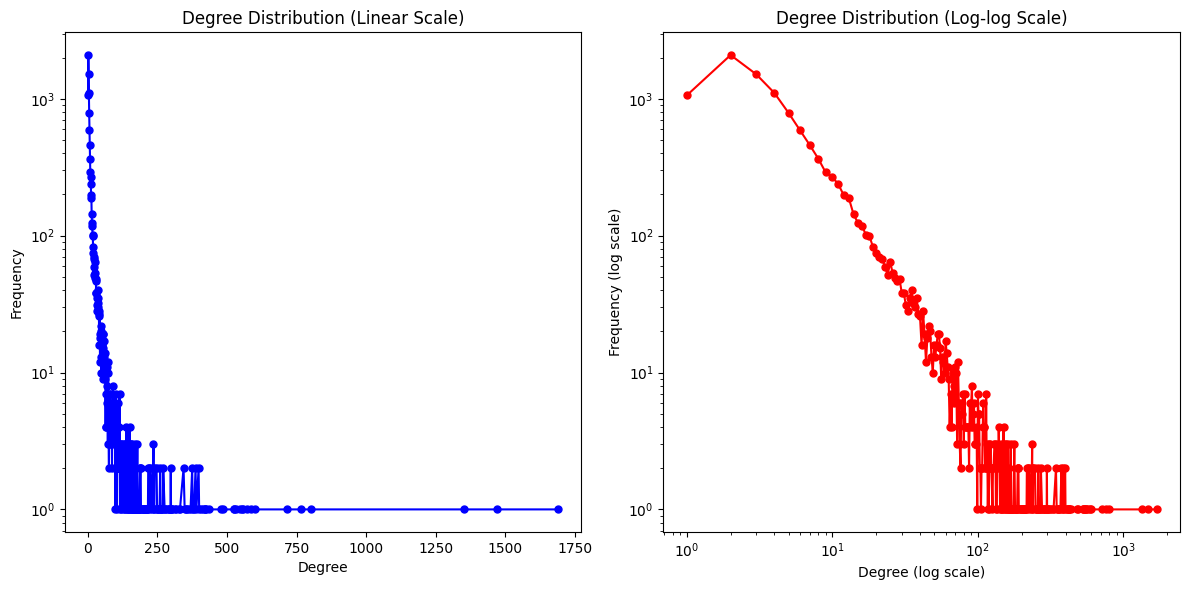

In [7]:
# Your degree sequence and degree count calculation
degree_sequence = sorted([d for n, d in Reddit_undirected.degree()], reverse=True)
degreeCount = {}
for degree in degree_sequence:
    if degree in degreeCount:
        degreeCount[degree] += 1
    else:
        degreeCount[degree] = 1
degrees, counts = zip(*degreeCount.items())

# Plotting the degree distribution (linear scale)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(degrees, counts, 'bo-', markersize=5)
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution (Linear Scale)')

# Plotting the degree distribution (log-log scale)
plt.subplot(1, 2, 2)
plt.loglog(degrees, counts, 'ro-', markersize=5)
plt.xlabel('Degree (log scale)')
plt.ylabel('Frequency (log scale)')
plt.title('Degree Distribution (Log-log Scale)')

plt.tight_layout()
plt.show()

# Attack functions

In [8]:
# Define the percentage of nodes to be removed at each step
PERC_TO_REMOVE = 0.10 # 10% of nodes to be removed at each step
NODES_TO_REMOVE = Reddit_undirected.number_of_nodes() * PERC_TO_REMOVE

In [9]:
def random_attack(graph, num_nodes_to_remove):
    """
    Perform a random attack on the graph, removing a given number of nodes at each iteration.
    
    Parameters:
    graph (nx.Graph): The input networkx graph.
    num_nodes_to_remove (int): Number of nodes to remove at each step.
    
    Returns:
    list: Sizes of the network at each step.
    """
    G = graph.copy()
    sizes = [{'removed_percentage': 0, 'num_nodes': G.number_of_nodes()}]
    step = 1
    
    while G.number_of_nodes() > 0:
        nodes_to_remove = random.sample(list(G.nodes()), min(num_nodes_to_remove, G.number_of_nodes()))
        G.remove_nodes_from(nodes_to_remove)

        # Take only the giant component after each removal
        G, giant_size = get_giant_component(G)
        removed_percentage = step * PERC_TO_REMOVE
        sizes.append({'removed_percentage': removed_percentage, 'num_nodes': giant_size})

        # If the graph is not connected anymore, break the loop
        if giant_size == 0:
            break

        step += 1
    
    return sizes

In [10]:
def targeted_attack(graph, num_nodes_to_remove, measure):
    """
    Perform a targeted attack on the graph, removing nodes based on a centrality measure.
    
    Parameters:
    graph (nx.Graph): The input networkx graph.
    num_nodes_to_remove (int): Number of nodes to remove at each step.
    measure (str): Centrality measure to use ('degree', 'pagerank', 'closeness', 'betweenness').
    
    Returns:
    list: Sizes of the network at each step.
    """
    G = graph.copy()
    sizes = [{'removed_percentage': 0, 'num_nodes': G.number_of_nodes()}]
    step = 1
    
    centrality_func = {
        'degree': nx.degree_centrality,
        'pagerank': nx.pagerank,
        'closeness': nx.closeness_centrality,
        'betweenness': nx.betweenness_centrality
    }
    
    if measure not in centrality_func:
        raise ValueError("Invalid measure. Choose from 'degree', 'pagerank', 'closeness', or 'betweenness'.")
    
    while G.number_of_nodes() > 0:
        centrality = centrality_func[measure](G)
        sorted_nodes = sorted(centrality, key=centrality.get, reverse=True)
        nodes_to_remove = sorted_nodes[:min(num_nodes_to_remove, len(sorted_nodes))]
        G.remove_nodes_from(nodes_to_remove)

        # Take only the giant component after each removal
        G, giant_size = get_giant_component(G)
        removed_percentage = step * PERC_TO_REMOVE
        sizes.append({'removed_percentage': removed_percentage, 'num_nodes': giant_size})

        # If the graph is not connected anymore, break the loop
        if giant_size == 0:
            break

        step += 1
    
    return sizes

# Plot Functions

In [11]:
import matplotlib.pyplot as plt

def plot_attack_results3(N, list_random_results, list_targeted_results, plot_titles):
    """
    Plot the results of random and targeted attacks on a graph for N subgraphs.
    
    Parameters:
    N (int): Number of subgraphs.
    list_random_results (list of lists): List containing N lists, each with results of the graph after each iteration of random attack.
    list_targeted_results (list of dicts): List containing N dictionaries, each with results of the graph after each iteration of targeted attack.
    plot_titles (list of str): List of titles for each subplot.
    """
    # Define the number of columns for the plot layout
    ncols = 2
    nrows = (N + ncols - 1) // ncols  # Calculate the number of rows needed
    
    # Create subplots
    fig, axes = plt.subplots(nrows, ncols, figsize=(15, 6 * nrows))
    axes = axes.flatten()  # Flatten the array of axes for easy iteration
    
    for i in range(N):
        random_results = list_random_results[i]
        targeted_results = list_targeted_results[i]
        
        ax = axes[i]

        # Extract data for plotting
        random_removed_percentages = [res['removed_percentage'] for res in random_results]
        random_num_nodes = [res['num_nodes'] for res in random_results]
        
        # Plot random attack
        ax.plot(random_removed_percentages, random_num_nodes, label='Random Attack', linestyle='--', marker='o')
        
        # Plot targeted attacks
        for measure, results in targeted_results.items():
            targeted_removed_percentages = [res['removed_percentage'] for res in results]
            targeted_num_nodes = [res['num_nodes'] for res in results]
            ax.plot(targeted_removed_percentages, targeted_num_nodes, label=f'Targeted Attack ({measure.capitalize()})', marker='o')
        
        # Plot normal progressive removal
        original_size = random_num_nodes[0]
        num_steps = int(100 / PERC_TO_REMOVE) + 1
        normal_removed_percentages = [PERC_TO_REMOVE * step / 100 for step in range(num_steps)]  # Normalize to 0-1
        normal_num_nodes = [original_size * (1 - p) for p in normal_removed_percentages]
        ax.plot(normal_removed_percentages, normal_num_nodes, label='Normal Progressive Removal', linestyle='-', color='black', linewidth=1)

        ax.set_xlabel('Removed nodes percentage')
        ax.set_ylabel('Size of Giant Component')
        ax.set_title(plot_titles[i])
        ax.legend()
        ax.grid(True)
    
    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


# Attacks

In [16]:
random_attack_sizes = random_attack(Reddit_undirected, int(NODES_TO_REMOVE))    

In [17]:
# Perform targeted attacks
measures = ['degree', 'pagerank', 'closeness', 'betweenness']
targeted_sizes = {measure: targeted_attack(Reddit_undirected, int(NODES_TO_REMOVE), measure) for measure in measures}

In [18]:
# Print the results of the attacks
print("Random attack sizes:", random_attack_sizes)
print("Degree attack sizes:", targeted_sizes['degree'])
print("Pagerank attack sizes:", targeted_sizes['pagerank'])
print("Closeness attack sizes:", targeted_sizes['closeness'])
print("Betweenness attack sizes:", targeted_sizes['betweenness'])

Random attack sizes: [{'removed_percentage': 0, 'num_nodes': 11564}, {'removed_percentage': 0.1, 'num_nodes': 10305}, {'removed_percentage': 0.2, 'num_nodes': 8992}, {'removed_percentage': 0.30000000000000004, 'num_nodes': 7684}, {'removed_percentage': 0.4, 'num_nodes': 6295}, {'removed_percentage': 0.5, 'num_nodes': 4839}, {'removed_percentage': 0.6000000000000001, 'num_nodes': 3260}, {'removed_percentage': 0.7000000000000001, 'num_nodes': 1684}, {'removed_percentage': 0.8, 'num_nodes': 281}, {'removed_percentage': 0.9, 'num_nodes': 0}]
Degree attack sizes: [{'removed_percentage': 0, 'num_nodes': 11564}, {'removed_percentage': 0.1, 'num_nodes': 7631}, {'removed_percentage': 0.2, 'num_nodes': 1469}, {'removed_percentage': 0.30000000000000004, 'num_nodes': 1}, {'removed_percentage': 0.4, 'num_nodes': 0}]
Pagerank attack sizes: [{'removed_percentage': 0, 'num_nodes': 11564}, {'removed_percentage': 0.1, 'num_nodes': 7390}, {'removed_percentage': 0.2, 'num_nodes': 1492}, {'removed_percenta

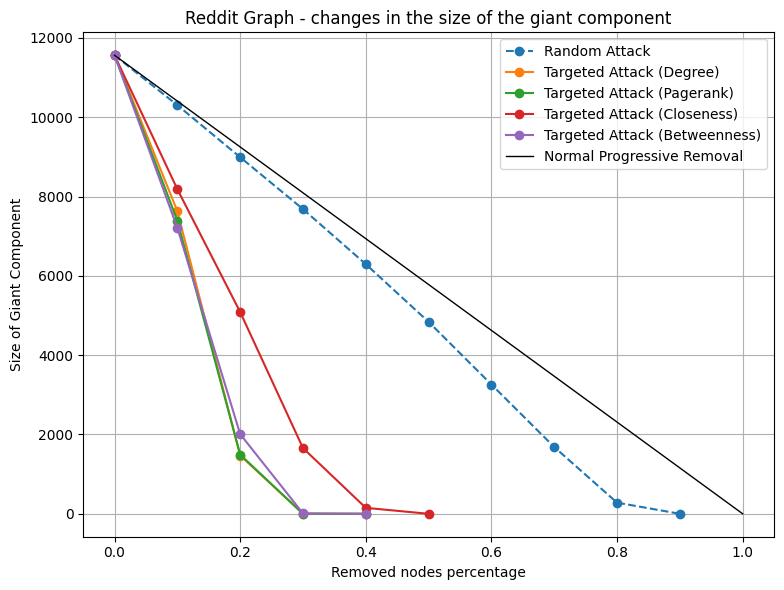

In [19]:
# Plot the results of the attacks
plot_attack_results3(1, [random_attack_sizes], [targeted_sizes], ['Reddit Graph - changes in the size of the giant component'])

# Improve robustness

## Connecting function

In [13]:
PERC_TO_ADD = 0.05 # 5% of most important nodes

In [14]:
def graph_statistics(basic_graph, new_graphs, new_graphs_name):
    # Function to compute graph statistics
    def compute_stats(graph):
        num_nodes = graph.number_of_nodes()
        num_edges = graph.number_of_edges()
        avg_degree = np.mean([d for n, d in graph.degree()])
        density = nx.density(graph)
        return num_nodes, num_edges, avg_degree, density

    # Initialize data with basic graph stats
    data = {
        "Graph": ["Basic Graph"],
        "Number of Nodes": [basic_graph.number_of_nodes()],
        "Number of Edges": [basic_graph.number_of_edges()],
        "Average Node Degree": [np.mean([d for n, d in basic_graph.degree()])],
        "Density of the Graph": [nx.density(basic_graph)]
    }

    # Compute stats for each new graph and append to data
    for i, new_graph in enumerate(new_graphs, start=1):
        num_nodes, num_edges, avg_degree, density = compute_stats(new_graph)
        data["Graph"].append(new_graphs_name[i-1])
        data["Number of Nodes"].append(num_nodes)
        data["Number of Edges"].append(num_edges)
        data["Average Node Degree"].append(avg_degree)
        data["Density of the Graph"].append(density)

    # Create DataFrame
    df = pd.DataFrame(data)

    return df

In [15]:
#function to add a certain number of edges according to a certain centrality measure

def add_edge_to_neighbour(G,arr_centrality,perc):
    G_new = G.copy()
    arr_centrality = sorted(arr_centrality.items(), key=lambda item: item[1], reverse=True)
    iteration_loop = int(G_new.number_of_nodes() * perc)

    for i in range(iteration_loop):
        high_centrality_node = arr_centrality[i % len(arr_centrality)][0]
        low_centrality_node = arr_centrality[-(i % len(arr_centrality)) - 1][0]

        neighbors = list(nx.all_neighbors(G_new, high_centrality_node))
        neighbors.append(high_centrality_node)

        for neighbour in neighbors:
            if not G_new.has_edge(low_centrality_node, neighbour):
                G_new.add_edge(low_centrality_node, neighbour)

    return G_new

def add_edge_to_neighbour_circle(G,arr_centrality,perc):
    G_new = G.copy()
    arr_centrality = sorted(arr_centrality.items(), key=lambda item: item[1], reverse=True)
    iteration_loop = int(G_new.number_of_nodes() * perc)

    for i in range(iteration_loop):
        high_centrality_node = arr_centrality[i % len(arr_centrality)][0]

        neighbors = list(nx.all_neighbors(G_new, high_centrality_node))
        neighbors.append(high_centrality_node)

        for i in range(len(neighbors)):
            if i == len(neighbors) - 1:
                neighbour = neighbors[0]
            else:
                neighbour = neighbors[i+1]

            if not G_new.has_edge(neighbors[i], neighbour):
                G_new.add_edge(neighbors[i], neighbour)
    return G_new

def add_community_edges(G):
    G_new = G.copy()
    # Add edges to bridge clusters
    communities = list(nx.algorithms.community.greedy_modularity_communities(G_new))
    for i in range(len(communities)):
        for j in range(i+1, len(communities)):
            # Adjust sample size to be the minimum of 10 or the size of the community
            sample_size1 = min(10, len(communities[i]))
            sample_size2 = min(10, len(communities[j]))
            
            node_from_comm1 = random.sample(list(communities[i]), sample_size1)
            node_from_comm2 = random.sample(list(communities[j]), sample_size2)
            
            for node1 in node_from_comm1:
                for node2 in node_from_comm2:
                    if not G_new.has_edge(node1, node2):
                        G_new.add_edge(node1, node2)
    return G_new

def add_random_edges(G,num_random_edges):
    G_new = G.copy()
    # Add random edges
    nodes = list(G_new.nodes())
    for _ in range(num_random_edges):
        u, v = random.sample(nodes, 2)
        if not G_new.has_edge(u, v):
            G_new.add_edge(u, v)
    return G_new 

## Improve robustness - Degree centrality

In [23]:
degree_centrality = nx.degree_centrality(Reddit_undirected)
Reddit_robust1 = add_edge_to_neighbour(Reddit_undirected,degree_centrality,PERC_TO_ADD)

random_attack_sizes1 = random_attack(Reddit_robust1, int(NODES_TO_REMOVE))

# Perform targeted attacks
measures = ['degree', 'pagerank', 'closeness', 'betweenness']
targeted_sizes1 = {measure: targeted_attack(Reddit_robust1, int(NODES_TO_REMOVE), measure) for measure in measures}

## Improve robustness - Community Bridges

In [27]:
Reddit_robust2 = add_community_edges(Reddit_undirected)
random_attack_sizes2 = random_attack(Reddit_robust2, int(NODES_TO_REMOVE))
targeted_sizes2 = {measure: targeted_attack(Reddit_robust2, int(NODES_TO_REMOVE), measure) for measure in measures}

## Improve robustness -  Random edges

In [29]:
Reddit_robust3 = add_random_edges(Reddit_undirected,int(Reddit_undirected.number_of_edges()/2))
random_attack_sizes3 = random_attack(Reddit_robust3, int(NODES_TO_REMOVE))
targeted_sizes3 = {measure: targeted_attack(Reddit_robust3, int(NODES_TO_REMOVE), measure) for measure in measures}

In [30]:
Reddit_robust4 = add_random_edges(Reddit_undirected,int(Reddit_undirected.number_of_edges()/4))
random_attack_sizes4 = random_attack(Reddit_robust3, int(NODES_TO_REMOVE))
targeted_sizes4 = {measure: targeted_attack(Reddit_robust4, int(NODES_TO_REMOVE), measure) for measure in measures}

## Improve robustness -  Betweenness centrality

In [31]:
betweenness_centrality = nx.betweenness_centrality(Reddit_undirected)
Reddit_robust5 = add_edge_to_neighbour(Reddit_undirected,betweenness_centrality,PERC_TO_ADD)

random_attack_sizes5 = random_attack(Reddit_robust5, int(NODES_TO_REMOVE))

# Perform targeted attacks
targeted_sizes5 = {measure: targeted_attack(Reddit_robust5, int(NODES_TO_REMOVE), measure) for measure in measures}

## Improve robustness -  Circle neighbours

In [17]:
degree_centrality = nx.degree_centrality(Reddit_undirected)

Reddit_robust6 = add_edge_to_neighbour_circle(Reddit_undirected,degree_centrality,PERC_TO_ADD)
random_attack_sizes6 = random_attack(Reddit_robust6, int(NODES_TO_REMOVE))

measures = ['degree', 'pagerank', 'closeness', 'betweenness']
targeted_sizes6 = {measure: targeted_attack(Reddit_robust6, int(NODES_TO_REMOVE), measure) for measure in measures}

## Results

In [38]:
basic_graph = Reddit_undirected
new_graphs = [Reddit_robust1,Reddit_robust2,Reddit_robust3, Reddit_robust4, Reddit_robust5]

# Get the statistics DataFrame
df = graph_statistics(basic_graph, new_graphs,["Degree centrality","Community Bridges","Random edges (40K)","Random edges (20K)","Betweenness centrality"])

# Print the DataFrame
print(tabulate(df, headers='keys', tablefmt='github'))

|    | Graph                  |   Number of Nodes |   Number of Edges |   Average Node Degree |   Density of the Graph |
|----|------------------------|-------------------|-------------------|-----------------------|------------------------|
|  0 | Basic Graph            |             11564 |             84812 |               14.6683 |             0.00126855 |
|  1 | Degree centrality      |             11564 |            185973 |               32.1641 |             0.00278164 |
|  2 | Community Bridges      |             11564 |            214942 |               37.1743 |             0.00321494 |
|  3 | Random edges (40K)     |             11564 |            127157 |               21.9919 |             0.00190192 |
|  4 | Random edges (20K)     |             11564 |            105983 |               18.3298 |             0.00158521 |
|  5 | Betweenness centrality |             11564 |            178313 |               30.8393 |             0.00266707 |


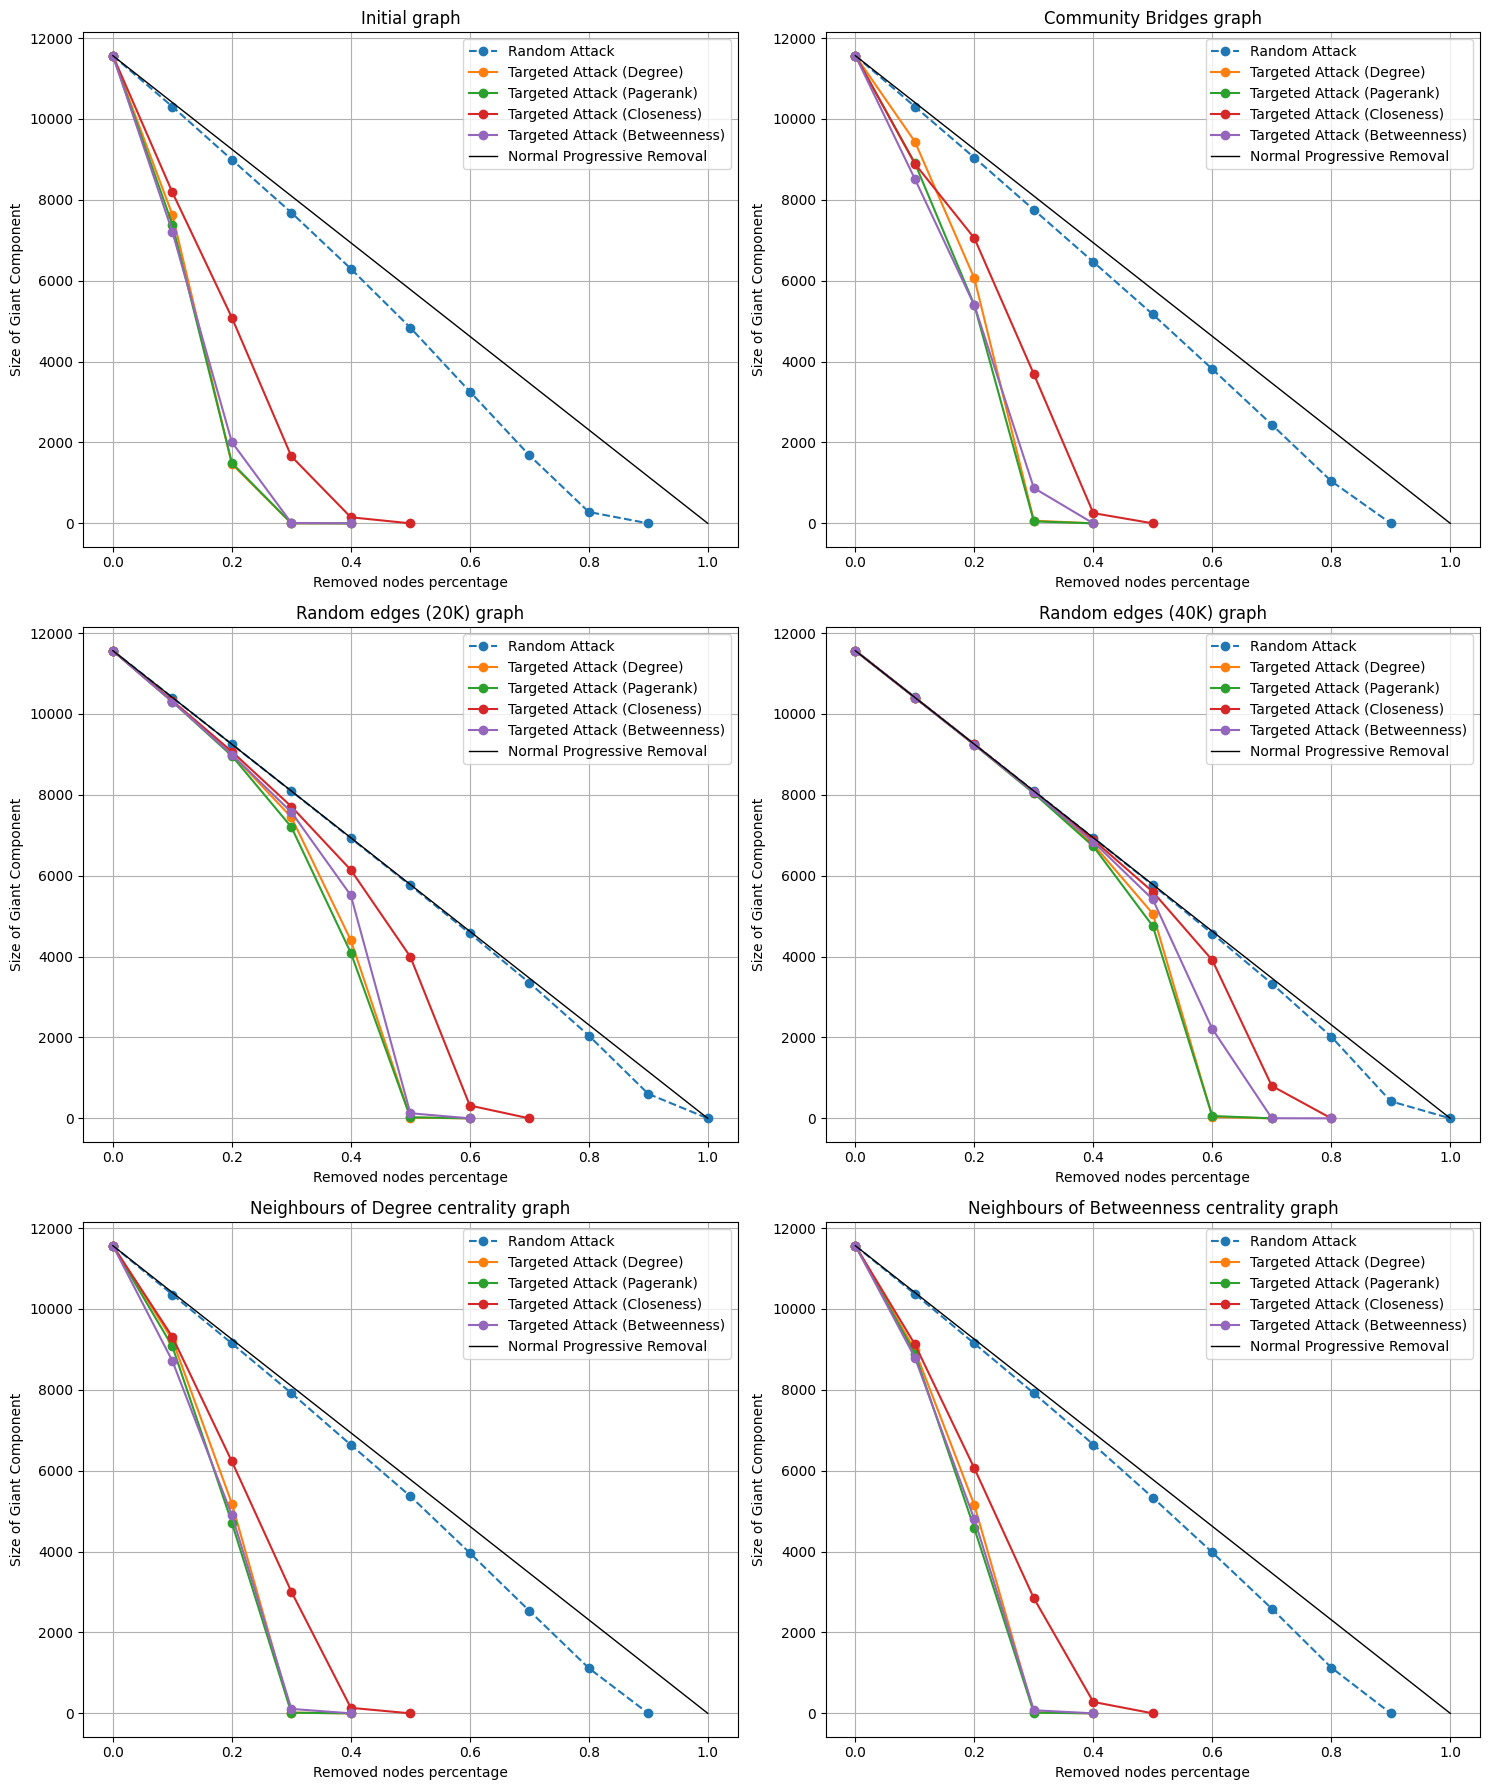

In [41]:
plot_attack_results3(len(new_graphs) + 1,
                      [random_attack_sizes,random_attack_sizes2,random_attack_sizes4,random_attack_sizes3,random_attack_sizes1, random_attack_sizes5],
                      [targeted_sizes,targeted_sizes2,targeted_sizes4,targeted_sizes3,targeted_sizes1,targeted_sizes5],
                      ["Initial graph","Community Bridges graph","Random edges (20K) graph","Random edges (40K) graph","Neighbours of Degree centrality graph","Neighbours of Betweenness centrality graph"])

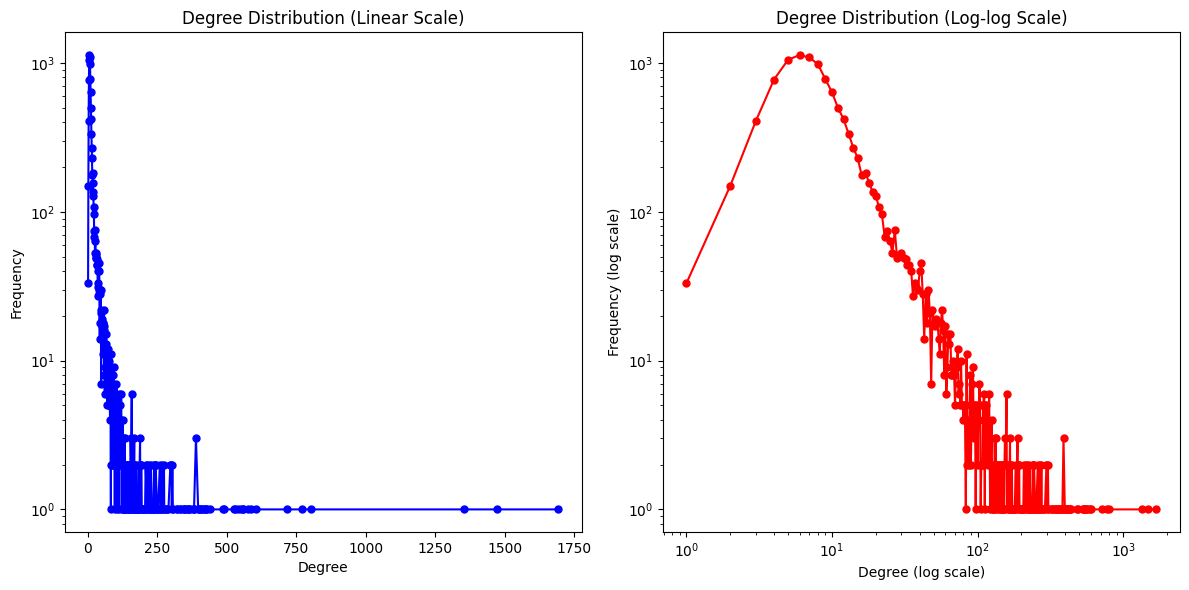

In [43]:
# Your degree sequence and degree count calculation
degree_sequence = sorted([d for n, d in Reddit_robust4.degree()], reverse=True)
degreeCount = {}
for degree in degree_sequence:
    if degree in degreeCount:
        degreeCount[degree] += 1
    else:
        degreeCount[degree] = 1
degrees, counts = zip(*degreeCount.items())

# Plotting the degree distribution (linear scale)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(degrees, counts, 'bo-', markersize=5)
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution (Linear Scale)')

# Plotting the degree distribution (log-log scale)
plt.subplot(1, 2, 2)
plt.loglog(degrees, counts, 'ro-', markersize=5)
plt.xlabel('Degree (log scale)')
plt.ylabel('Frequency (log scale)')
plt.title('Degree Distribution (Log-log Scale)')

plt.tight_layout()
plt.show()

## Other results

In [19]:
basic_graph = Reddit_undirected
new_graphs = [Reddit_robust6]

# Get the statistics DataFrame
df = graph_statistics(basic_graph, new_graphs,["Degree circle neighbours"])

# Print the DataFrame
print(tabulate(df, headers='keys', tablefmt='github'))

|    | Graph                    |   Number of Nodes |   Number of Edges |   Average Node Degree |   Density of the Graph |
|----|--------------------------|-------------------|-------------------|-----------------------|------------------------|
|  0 | Basic Graph              |             11564 |             84812 |               14.6683 |             0.00126855 |
|  1 | Degree circle neighbours |             11564 |            166725 |               28.8352 |             0.00249375 |


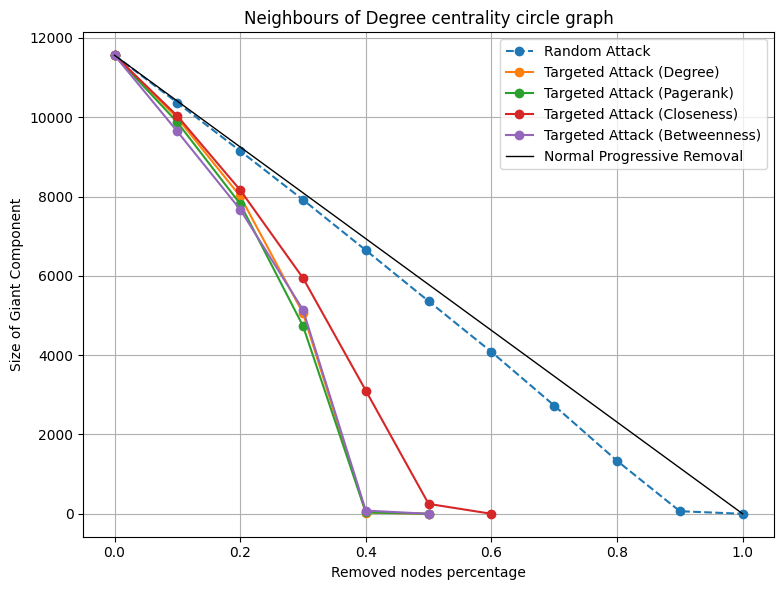

In [21]:
plot_attack_results3(len(new_graphs),[random_attack_sizes6],[targeted_sizes6],["Neighbours of Degree centrality circle graph"])